In [1]:
import pandas as pd
import numpy as np
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.errors import PerformanceWarning

warnings.simplefilter(action="ignore", category=PerformanceWarning)

In [2]:
###PRE-PROCESS###

# Load the dataset
df = pd.read_excel("/content/drive/MyDrive/MAN456/project/full_data.xlsx")
# Drop duplicate rows
df = df.drop_duplicates()


###DROPPING THE OUTLIER (EARTHQUAKE DATA)
df['Date'] = pd.to_datetime(df['Date'])

# Define the date range to drop
start_date = pd.Timestamp('2023-02-06')
end_date = pd.Timestamp('2023-03-23')

# Drop rows in the specified date range
df = df[~df['Date'].between(start_date, end_date)]

# Clean parentheses and whitespace from dish names
def clean_main_dish(name):
    name = re.sub(r'\s*\(.*?\)', '', name)
    name = name.strip()
    name = re.sub(' +', ' ', name)
    return name

df["Main Dish"] = df["Main Dish"].apply(clean_main_dish)
df["Side Dish"] = df["Side Dish"].apply(clean_main_dish)
df["Extra Dish"] = df["Extra Dish"].apply(clean_main_dish)
import unicodedata

def to_ascii(text):
    if pd.isna(text): return text
    nfkd = unicodedata.normalize('NFKD', str(text))
    return nfkd.encode('ascii','ignore').decode('ascii')

str_cols = df.select_dtypes(include=['object']).columns
for c in str_cols:
    df[c] = df[c].apply(to_ascii)
# Normalize "Salata" types into a single category
def normalize_salata(name):
    if pd.isnull(name):
        return name
    if 'salata' in name.lower():
        return 'Salata'
    return name

df["Side Dish"] = df["Side Dish"].apply(normalize_salata)
df["Extra Dish"] = df["Extra Dish"].apply(normalize_salata)
df['main dish_tavuk'] = df['Main Dish'].str.lower().str.contains('tavuk|piliç|pilic|pılıc|pılıç').astype(int)
df['main dish_köfte']= df['Main Dish'].str.lower().str.contains('kofte').astype(int)
df['main dish_kebap'] = df['Main Dish'].str.lower().str.contains('kebap|kebabı|kebabi').astype(int)
df['main dish_balık'] = df['Main Dish'].str.lower().str.contains('balık|sardalya|hamsi|mezgit|balik|mezgıt|hamsı').astype(int)

# Merge binary features from Side Dish and Extra Dish
def merge_dish_columns(df, side_dish_col, extra_dish_col, item_list):
    for item in item_list:
        df[item] = ((df[side_dish_col] == item) | (df[extra_dish_col] == item)).astype(int)
    return df

urunler = pd.unique(df[['Side Dish', 'Extra Dish']].values.ravel())
df = merge_dish_columns(df, side_dish_col='Side Dish', extra_dish_col='Extra Dish', item_list=urunler)

# Prepare year and features
df["year"] = df["Date"].dt.year.astype('category')
df["month"] = df["Date"].dt.month.astype('category')
df['Ramadan_Is_evening'] = df['Ramadan'] * df['Is_evening?']
df['Ramadan_Is_daytime'] = df['Ramadan'] * (1 - df['Is_evening?'])


X = df.drop(['Date', 'Fix_Value', 'Side Dish', 'Extra Dish'], axis=1)
Y = df['Fix_Value']

# Add constant for statsmodels
X = sm.add_constant(X)

# One-hot encoding for categorical variables
encoded_X = pd.get_dummies(X).astype(int)
# Drop individual 'tavuk' dishes based on Main Dish
keep_main_dishes = ['main dish_tavuk', 'main dish_köfte', 'main dish_kebap']

# Drop individual 'tavuk' and 'piliç' dishes (except the general one)
tavuk_keywords = ['tavuk', 'piliç','pilic','pılıç','pılıç']
tavuk_dish_cols = [col for col in encoded_X.columns
                   if col.startswith('Main Dish_')
                   and any(kw in col.lower() for kw in tavuk_keywords)
                   and col.lower() not in keep_main_dishes]

kebap_keywords = ['kebap', 'kebabı', 'kebabi']
kebap_dish_cols = [col for col in encoded_X.columns
                   if col.startswith('Main Dish_')
                   and any(kw in col.lower() for kw in kebap_keywords)
                   and col.lower() not in keep_main_dishes]

kofte_keywords = ['kofte']
kofte_dish_cols = [col for col in encoded_X.columns
                   if col.startswith('Main Dish_')
                   and any(kw in col.lower() for kw in kofte_keywords)
                   and col.lower() not in keep_main_dishes]

balık_keywords = ['balık', 'balik', 'sardalya', 'hamsi', 'hamsı', 'mezgıt','mezgit']
balık_dish_cols = [col for col in encoded_X.columns
                   if col.startswith('Main Dish_')
                   and any(kw in col.lower() for kw in balık_keywords)
                   and col.lower() not in keep_main_dishes]
# Drop individual red meat dishes

to_drop = tavuk_dish_cols + kebap_dish_cols + kofte_dish_cols+ balık_dish_cols
encoded_X = encoded_X.drop(columns=to_drop)

# Drop low-occurrence columns
low_occurrence_cols = [col for col in encoded_X.columns if encoded_X[col].sum() < 2]
encoded_X = encoded_X.drop(columns=low_occurrence_cols)

dishes_to_drop = ['IRMIK HELVASI', 'TAHIN HELVA', 'ZY. BARBUNYA', 'TURSU','Soup_SEHRIYE CORBA', 'Semester_Fall', 'Semester_Spring']
cols_to_drop = [col for col in encoded_X.columns if any(dish in col for dish in dishes_to_drop)]
encoded_X = encoded_X.drop(columns=cols_to_drop)

# Split the dataset
train_X, test_X, train_Y, test_Y = train_test_split(encoded_X, Y, test_size=0.2, random_state=42)


<ipython-input-2-0b24f3655a1a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


In [3]:
#LINEAR MODEL

log_train_Y = np.log(train_Y)
data_lm = sm.OLS( log_train_Y, train_X ).fit()
data_lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Ordinary least squares
=================================================================================
Model:                   OLS                   Adj. R-squared:          0.652    
Dependent Variable:      Fix_Value             AIC:                     2130.3425
Date:                    2025-05-08 19:51      BIC:                     3202.2555
No. Observations:        1081                  Log-Likelihood:          -850.17  
Df Model:                214                   F-statistic:             10.47    
Df Residuals:            866                   Prob (F-statistic):      3.27e-141
R-squared:               0.721                 Scale:                   0.35233  
---------------------------------------------------------------------------------
                                  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------
const                             3.7245   0.1966  18.9409 0.0000  3.3385  4.1104
Is_evening?                      -0.2546   0.0436  -5.8356 0.0000 -0.3402 -0.1689
Is_holiday?                      -0.9412   0.1069  -8.8083 0.0000 -1.1509 -0.7315
Ramadan                           0.0017   0.0733   0.0233 0.9814 -0.1422  0.1456
Is_final_time?                   -0.2194   0.0862  -2.5451 0.0111 -0.3887 -0.0502
main dish_tavuk                   0.2645   0.2037   1.2985 0.1944 -0.1353  0.6643
main dish_köfte                   0.1616   0.2110   0.7659 0.4440 -0.2525  0.5756
main dish_kebap                   0.1007   0.2016   0.4995 0.6176 -0.2950  0.4963
main dish_balık                   0.1283   0.3508   0.3658 0.7146 -0.5602  0.8168
BULGUR PILAVI                    -0.1487   0.1378  -1.0793 0.2808 -0.4192  0.1217
YOGURT                            0.1037   0.1317   0.7879 0.4310 -0.1547  0.3621
SU BOREGI                        -0.0237   0.2011  -0.1177 0.9063 -0.4184  0.3711
ELMA                              0.0304   0.1617   0.1879 0.8510 -0.2869  0.3477
Salata                            0.0766   0.1323   0.5790 0.5627 -0.1831  0.3363
SUTLAC                            0.0162   0.1958   0.0828 0.9340 -0.3682  0.4006
SEH. PIRINC PILAVI                0.1179   0.2363   0.4991 0.6178 -0.3458  0.5817
KASARLI ERISTE                   -0.1436   0.1652  -0.8688 0.3852 -0.4679  0.1808
CIKOLATALI IRMIK TATLISI         -0.0346   0.1932  -0.1792 0.8579 -0.4137  0.3445
SPAGETTI NAPOLITEN               -0.1311   0.1852  -0.7080 0.4791 -0.4946  0.2323
AYRAN                             0.1399   0.1422   0.9836 0.3256 -0.1393  0.4190
PEYNIRLI RULO BOREK              -0.1050   0.3209  -0.3273 0.7435 -0.7348  0.5248
PORTAKAL                         -0.0352   0.1806  -0.1948 0.8456 -0.3896  0.3193
TULUMBA TATLISI                  -0.1222   0.2241  -0.5452 0.5858 -0.5621  0.3177
PEYNIRLI GUL BOREGI              -0.3058   0.2738  -1.1171 0.2643 -0.8432  0.2315
MANDALINA                        -0.0158   0.1917  -0.0827 0.9341 -0.3922  0.3605
ELBASAN TATLISI                  -0.1798   0.2454  -0.7326 0.4640 -0.6615  0.3019
YOGURTLU MAKARNA                  0.7721   0.4856   1.5900 0.1122 -0.1810  1.7253
CIKOLATALI PUDING                 0.1518   0.3733   0.4067 0.6844 -0.5808  0.8844
KASARLI CEVIZLI ERISTE           -0.0732   0.1851  -0.3955 0.6925 -0.4365  0.2901
ARPA SEHRIYE PILAVI              -0.0174   0.1421  -0.1225 0.9025 -0.2962  0.2614
MUZ                               0.1192   0.1573   0.7573 0.4491 -0.1896  0.4279
MUHALLEBILI CEZERYE              -0.2906   0.2269  -1.2808 0.2006 -0.7360  0.1548
PIRINC PILAVI                    -0.1201   0.1603  -0.7493 0.4539 -0.4347  0.1945
ISPANAKLI RULO BOREK             -0.1007   0.3176  -0.3170 0.7513 -0.7241  0.5227
PEYNIRLI SPAGETTI                -0.4230   0.2474  -1.7096 0.0877 -0.9086  0.0626
SUP                               0.1457   0.1873   0.7780 0.4368 -0.2219  0.5133
KAHVELI KARAMELLI SARLOT          0.1420

In [4]:
def backward_elimination(X, y, significance_level=0.05):
    X = X.copy()
    while True:
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues
        max_p_value = p_values.max()

        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            print(f"Dropping '{excluded_feature}' with p-value {max_p_value}")
            X = X.drop(columns=[excluded_feature])
        else:
            break
    return X, model

selected_X, final_model = backward_elimination(train_X, log_train_Y)

print(final_model.summary2())

Dropping 'KROKANLI MUHALLEBI' with p-value 0.9868178677735246
Dropping 'Ramadan' with p-value 0.9816556249565829
Dropping 'Main Dish_SEBZELI ET SOTE' with p-value 0.9706919255056964
Dropping 'PEYNIR TATLISI' with p-value 0.9648785566899278
Dropping 'LOKMA TATLISI' with p-value 0.9591753745243887
Dropping 'MANDALINA' with p-value 0.9470847487933873
Dropping 'Main Dish_KIYMALI ISPANAK' with p-value 0.9441003185261934
Dropping 'LIMONLU KESKUL' with p-value 0.9388819632645388
Dropping 'ARPA SEHRIYE PILAVI' with p-value 0.9357300253717105
Dropping 'SU BOREGI' with p-value 0.9446047539269564
Dropping 'SOSLU MAKARNA' with p-value 0.9477994751789145
Dropping 'SARI BURMA' with p-value 0.9385786911672662
Dropping 'SUNGER TATLISI' with p-value 0.9396774125941882
Dropping 'MUZLU SARLOT' with p-value 0.928601982405228
Dropping 'KREM SOKOLA' with p-value 0.9242065221215958
Dropping 'CIKOLATALI IRMIK TATLISI' with p-value 0.9129487871526818
Dropping 'YOGURT TATLISI' with p-value 0.9046873304234786
Dr

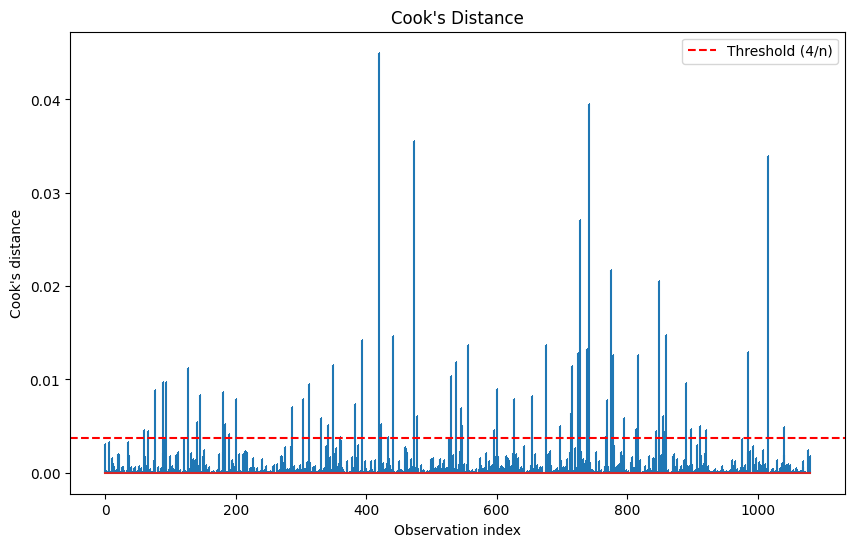

In [5]:
##OUTLIER ELIMINATION

# Cook's distance values
influence = final_model.get_influence()
(c, p) = influence.cooks_distance

# Plot Cook's distance without use_line_collection
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(c)), c, markerfmt=",")  # removed use_line_collection
plt.axhline(4/len(train_X), color='r', linestyle='--', label='Threshold (4/n)')
plt.title("Cook's Distance")
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.legend()
plt.show()

threshold = 0.02
outlier_indices = np.where(c > threshold)[0]

# Drop those rows from train_X and train_Y
train_X_filtered = train_X.drop(train_X.index[outlier_indices])
train_Y_filtered = train_Y.drop(train_Y.index[outlier_indices])

log_train_Y_filtered = np.log(train_Y_filtered)

In [6]:
#FINAL LINEAR MODEL

selected_X, final_model = backward_elimination(train_X_filtered, log_train_Y_filtered)

print(final_model.summary2())

Dropping 'Soup_CERKEZ CORBA' with p-value 0.9945004352054019
Dropping 'BAKLAVA' with p-value 0.9941081290042559
Dropping 'PEYNIRLI MAKARNA' with p-value 0.9905676007882072
Dropping 'Soup_SEBZE CORBA' with p-value 0.9837309023048344
Dropping 'HAVUC DILIMI BAKLAVA' with p-value 0.9645082696674486
Dropping 'KALBURABASTI' with p-value 0.9529897387261319
Dropping 'KROKANLI MUHALLEBI' with p-value 0.9536433230276622
Dropping 'CILEKLI SARLOT' with p-value 0.9342061540408283
Dropping 'Main Dish_SEBZELI ET SOTE' with p-value 0.930070024084213
Dropping 'ZEYTINYAGLI KABAK' with p-value 0.9307378283935295
Dropping 'MISIRLI PIRINC PILAVI' with p-value 0.9216516429682124
Dropping 'BROWNIE' with p-value 0.9232002661038571
Dropping 'Day of Week_Sunday' with p-value 0.90440144237681
Dropping 'ISP. RULO BOREK' with p-value 0.9042164212901447
Dropping 'CAYKENT TATLISI' with p-value 0.9004232109119045
Dropping 'FINDIKLI KESKUL' with p-value 0.9003096032107489
Dropping 'YOGURT TATLISI' with p-value 0.89357

In [7]:
#LINEAR MODEL PERFORMANCE

predictions = np.exp(final_model.predict(test_X[selected_X.columns]))

# Evaluate the model
mse = mean_squared_error(test_Y, predictions)
r2 = r2_score(test_Y, predictions)
mae = np.mean(np.abs(test_Y - predictions))
mape = np.mean(np.abs((test_Y - predictions) / test_Y)) * 100

print(f"Test R^2: {r2}")
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test MAPE: {mape}")

Test R^2: 0.7102295771704047
Test MSE: 55024.33328580059
Test MAE: 155.54344616459113
Test MAPE: 51.762125854522154


In [8]:
#LASSO REGRESSION

# 1) fit a Lasso with built-in CV (5-fold here)
lasso = LassoCV(cv=5, n_jobs=-1, random_state=42).fit(train_X_filtered, log_train_Y_filtered)

# 2) extract non-zero coefficients
coef = pd.Series(lasso.coef_, index=train_X_filtered.columns)
selected = coef[coef.abs() > 1e-8].index.tolist()
print(f"Kept {len(selected)} features out of {train_X.shape[1]}")

forced = 'main dish_balık'
if forced not in selected and forced in train_X_filtered.columns:
    print(f"Adding back {forced}")
    selected.append(forced)

# 3) reduce your design matrices
train_X_lasso = train_X_filtered[selected]
test_X_lasso  = test_X[selected]

# 4) (optional) refit an unpenalized OLS on the reduced set
import statsmodels.api as sm
ols = sm.OLS(log_train_Y_filtered, sm.add_constant(train_X_lasso)).fit()
print(ols.summary2())


Kept 47 features out of 220
Adding back main dish_balık
                         Results: Ordinary least squares
Model:                   OLS                   Adj. R-squared:          0.698    
Dependent Variable:      Fix_Value             AIC:                     1822.6660
Date:                    2025-05-08 19:51      BIC:                     2066.6441
No. Observations:        1074                  Log-Likelihood:          -862.33  
Df Model:                48                    F-statistic:             52.67    
Df Residuals:            1025                  Prob (F-statistic):      1.14e-240
R-squared:               0.712                 Scale:                   0.30564  
---------------------------------------------------------------------------------
                                  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------
const                             6.4946   0.0835  77.7864 0.0000  

In [9]:
#LASSO PERFORMANCE

lasso_predictions = np.exp(ols.predict(sm.add_constant(test_X_lasso)))

# Evaluate the Lasso model
lasso_mse = mean_squared_error(test_Y, lasso_predictions)
lasso_r2 = r2_score(test_Y, lasso_predictions)
lasso_mae = np.mean(np.abs(test_Y - lasso_predictions))
lasso_mape= np.mean(np.abs((test_Y - lasso_predictions) / test_Y)) * 100

print(f"Lasso Test R^2: {lasso_r2}")
print(f"Lasso Test MSE: {lasso_mse}")
print(f"Lasso Test MAE: {lasso_mae}")
print(f"Lasso Test MAPE: {lasso_mape}")

Lasso Test R^2: 0.7192432323138879
Lasso Test MSE: 53312.735670367096
Lasso Test MAE: 151.38743381100153
Lasso Test MAPE: 51.82664607676204


In [10]:
##LGBM MODEL

lgbm_model = LGBMRegressor(learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.8)
lgbm_model.fit(train_X_filtered, log_train_Y_filtered)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 1074, number of used features: 95
[LightGBM] [Info] Start training from score 5.816387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

LGBMRegressor(max_depth=10, subsample=0.8)

In [11]:
#LGBM PERFORMANCE

test_predictions_log = lgbm_model.predict(test_X)
test_predictions = np.expm1(test_predictions_log)
train_predictions_log = lgbm_model.predict(train_X_filtered)
train_predictions = np.expm1(train_predictions_log)
# Calculate metrics for the test set
test_mse = mean_squared_error(test_Y, test_predictions)
test_mae = mean_absolute_error(test_Y, test_predictions)
test_r2 = r2_score(test_Y, test_predictions)
train_r2 = r2_score(train_Y_filtered, train_predictions)
test_mape = np.mean(np.abs((test_Y - test_predictions) / test_Y)) * 100
# Print the results
print("LightGBM (log transformed target):")
print(f"  Test: MSE={test_mse:.2f}, MAPE={test_mape:.2f}, MAE={test_mae:.2f}, R²={test_r2:.3f}, Train R²={train_r2:.3f}")

LightGBM (log transformed target):
  Test: MSE=45544.21, MAPE=54.56, MAE=138.30, R²=0.760, Train R²=0.814


In [12]:
#RANDOM FOREST

# Initialize and train the Random Forest model with the best hyperparameters
rf_model = RandomForestRegressor(max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42)
rf_model.fit(train_X_filtered, log_train_Y_filtered)

# Make predictions
rf_predictions_log = rf_model.predict(test_X)
rf_predictions = np.expm1(rf_predictions_log)

# Evaluate the model
rf_mse = mean_squared_error(test_Y, rf_predictions)
rf_mape = np.mean(np.abs((test_Y - rf_predictions) / test_Y)) * 100
rf_mae = mean_absolute_error(test_Y, rf_predictions)
rf_r2 = r2_score(test_Y, rf_predictions)

train_predictions_log = rf_model.predict(train_X_filtered)
train_predictions = np.expm1(train_predictions_log)
train_r2 = r2_score(train_Y_filtered, train_predictions)

print("Random Forest:")
print(f"  Test: MSE={rf_mse:.2f}, MAPE={rf_mape:.2f}, MAE={rf_mae:.2f}, R²_test={rf_r2:.3f}, R2_train={train_r2}")


Random Forest:
  Test: MSE=51155.94, MAPE=65.25, MAE=153.43, R²_test=0.731, R2_train=0.8388739326840159


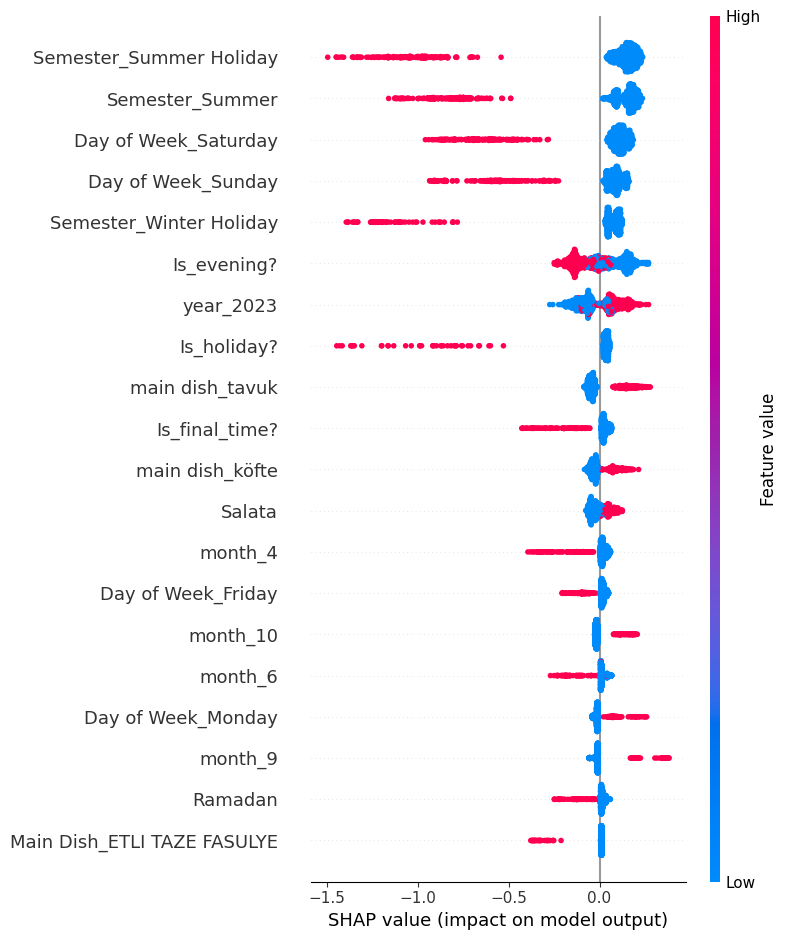

In [13]:

explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(train_X_filtered)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, train_X_filtered)


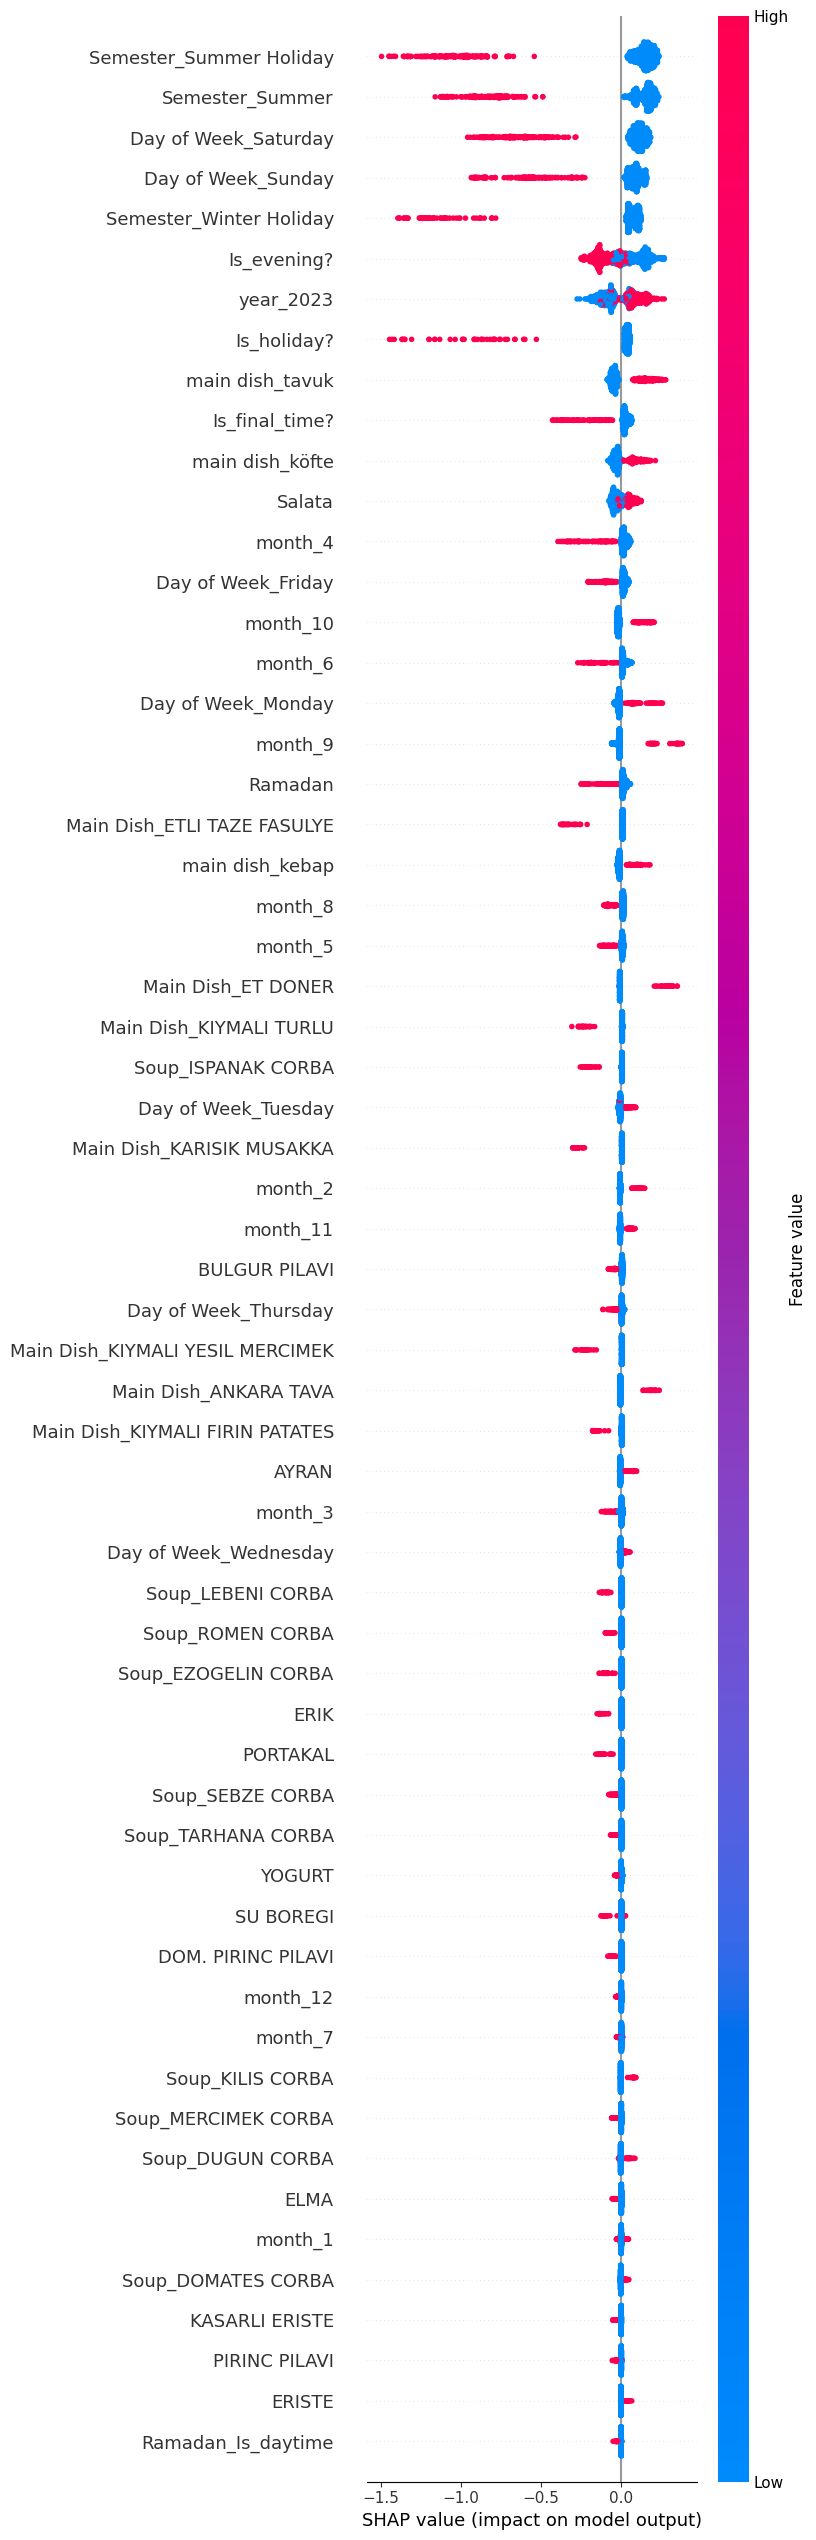

In [14]:
shap.summary_plot(shap_values, train_X_filtered, max_display=60)


In [15]:
####Result
import numpy as np

# Filter the test data to exclude Ramadan, final exam week, holidays, and only keep Spring/Fall semesters
valid_conditions = (
    (test_X['Ramadan_Is_daytime'] == 0) &  # Not Ramadan (daytime)
    (test_X['Semester_Summer Holiday'] == 0) &  # Not summer holiday
    (test_X['Semester_Summer'] == 0) &  # Not summer semester
    (test_X['Semester_Winter Holiday'] == 0) &  # Not winter holiday
    (test_X['Is_holiday?'] == 0) &  # Not holiday
    (test_X['Is_final_time?'] == 0)  # Not final exam period
)

# Apply the filter to the test set to get valid data points
filtered_test_X = test_X[valid_conditions]
filtered_test_Y = test_Y[valid_conditions]

# Select one week from the filtered test set (ensure that we have 7 days)
one_week_X = filtered_test_X.iloc[:7]
one_week_Y = filtered_test_Y.iloc[:7].values  # real demand for the selected week

# Predict using the model
week_predictions_log = lgbm_model.predict(one_week_X)
week_predictions = np.expm1(week_predictions_log)

# Identify actual days for this filtered data (for determining weekdays vs weekends)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_columns = [f'Day of Week_{d}' for d in day_names]
actual_days = one_week_X[day_columns].idxmax(axis=1).str.replace('Day of Week_', '')

# Create baseline plan: 900 for weekdays, 303 for weekends
baseline_plan = actual_days.apply(lambda d: 900 if d in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 303).values

# Waste under baseline plan
waste_baseline = np.maximum(baseline_plan - one_week_Y, 0)
total_waste_baseline = np.sum(waste_baseline)

# Waste under model plan
waste_model = np.maximum(week_predictions - one_week_Y, 0)
total_waste_model = np.sum(waste_model)

# Shortage under baseline plan
shortage_baseline = np.maximum(one_week_Y - baseline_plan, 0)
total_shortage_baseline = np.sum(shortage_baseline)

# Shortage under model plan
shortage_model = np.maximum(one_week_Y - week_predictions, 0)
total_shortage_model = np.sum(shortage_model)

# Total actual demand (for percentage calculations)
total_actual_demand = np.sum(one_week_Y)

# Percentage calculations
waste_baseline_pct = (total_waste_baseline / total_actual_demand) * 100
waste_model_pct = (total_waste_model / total_actual_demand) * 100
shortage_baseline_pct = (total_shortage_baseline / total_actual_demand) * 100
shortage_model_pct = (total_shortage_model / total_actual_demand) * 100

# Print results
print("Actual days of the week:", actual_days.values)
print("Real demand each day:", one_week_Y)
print("Model predictions:", np.round(week_predictions, 1))
print("Baseline plan (900 weekday, 303 weekend):", baseline_plan)

print(f"\nTotal waste (baseline plan): {total_waste_baseline:.1f} meals ({waste_baseline_pct:.1f}%)")
print(f"Total waste (model plan): {total_waste_model:.1f} meals ({waste_model_pct:.1f}%)")

print(f"\nTotal shortage (baseline plan): {total_shortage_baseline:.1f} meals ({shortage_baseline_pct:.1f}%)")
print(f"Total shortage (model plan): {total_shortage_model:.1f} meals ({shortage_model_pct:.1f}%)")


Actual days of the week: ['Wednesday' 'Wednesday' 'Friday' 'Monday' 'Thursday' 'Friday' 'Wednesday']
Real demand each day: [1542  680 1009 1208  490  673  779]
Model predictions: [1502.9  780.4  874.1  641.1  489.1  673.5  889.8]
Baseline plan (900 weekday, 303 weekend): [900 900 900 900 900 900 900]

Total waste (baseline plan): 978.0 meals (15.3%)
Total waste (model plan): 211.8 meals (3.3%)

Total shortage (baseline plan): 1059.0 meals (16.6%)
Total shortage (model plan): 741.8 meals (11.6%)


In [16]:


# Filter the test data to exclude Ramadan, final exam week, holidays, and only keep Spring/Fall semesters
valid_conditions = (
    (test_X['Ramadan_Is_daytime'] == 0) &  # Not Ramadan (daytime)
    (test_X['Semester_Summer Holiday'] == 0) &  # Not summer holiday
    (test_X['Semester_Summer'] == 0) &  # Not summer semester
    (test_X['Semester_Winter Holiday'] == 0) &  # Not winter holiday
    (test_X['Is_holiday?'] == 0) &  # Not holiday
    (test_X['Is_final_time?'] == 0)  # Not final exam period
)

# Apply the filter to the test set to get valid data points
filtered_test_X = test_X[valid_conditions]
filtered_test_Y = test_Y[valid_conditions]

# Select weekends from the filtered test set
weekend_X = filtered_test_X[filtered_test_X['Day of Week_Saturday'] == 1]
weekend_Y = filtered_test_Y[filtered_test_X['Day of Week_Saturday'] == 1].values

# Predict using the model for the weekend data
weekend_predictions_log = lgbm_model.predict(weekend_X)
weekend_predictions = np.expm1(weekend_predictions_log)

# Create baseline plan for weekends: 303 meals
baseline_plan_weekends = np.full(len(weekend_Y), 303)

# Waste under baseline plan for weekends
waste_baseline_weekends = np.maximum(baseline_plan_weekends - weekend_Y, 0)
total_waste_baseline_weekends = np.sum(waste_baseline_weekends)

# Waste under model plan for weekends
waste_model_weekends = np.maximum(weekend_predictions - weekend_Y, 0)
total_waste_model_weekends = np.sum(waste_model_weekends)

# Shortage under baseline plan for weekends
shortage_baseline_weekends = np.maximum(weekend_Y - baseline_plan_weekends, 0)
total_shortage_baseline_weekends = np.sum(shortage_baseline_weekends)

# Shortage under model plan for weekends
shortage_model_weekends = np.maximum(weekend_Y - weekend_predictions, 0)
total_shortage_model_weekends = np.sum(shortage_model_weekends)

# Calculate total actual weekend demand for percentage calculations
total_actual_weekend_demand = np.sum(weekend_Y)

# Percentage calculations
waste_baseline_pct = (total_waste_baseline_weekends / total_actual_weekend_demand) * 100
waste_model_pct = (total_waste_model_weekends / total_actual_weekend_demand) * 100
shortage_baseline_pct = (total_shortage_baseline_weekends / total_actual_weekend_demand) * 100
shortage_model_pct = (total_shortage_model_weekends / total_actual_weekend_demand) * 100

# Print outputs
print("Real demand each weekend day (first 7 days):", weekend_Y[:7])
print("Model predictions for weekends (first 7 days):", np.round(weekend_predictions[:7], 1))
print("Baseline plan (303 weekend) for first 7 days:", baseline_plan_weekends[:7])

print(f"\n--- Weekend Results ---")
print(f"Total waste (baseline plan - weekends): {total_waste_baseline_weekends:.1f} meals ({waste_baseline_pct:.1f}%)")
print(f"Total waste (model plan - weekends): {total_waste_model_weekends:.1f} meals ({waste_model_pct:.1f}%)")
print(f"Total shortage (baseline plan - weekends): {total_shortage_baseline_weekends:.1f} meals ({shortage_baseline_pct:.1f}%)")
print(f"Total shortage (model plan - weekends): {total_shortage_model_weekends:.1f} meals ({shortage_model_pct:.1f}%)")


Real demand each weekend day (first 7 days): [281 414 210 145 440 225 628]
Model predictions for weekends (first 7 days): [196.5 330.3 219.8 260.7 393.1 179.2 661.8]
Baseline plan (303 weekend) for first 7 days: [303 303 303 303 303 303 303]

--- Weekend Results ---
Total waste (baseline plan - weekends): 757.0 meals (14.5%)
Total waste (model plan - weekends): 520.7 meals (10.0%)
Total shortage (baseline plan - weekends): 1138.0 meals (21.8%)
Total shortage (model plan - weekends): 609.1 meals (11.6%)
